In [1]:
from __future__ import division, print_function
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string
dataset_size = 500

Using TensorFlow backend.


In [ ]:
stopword_ls = []
def getStopWord():
    with open('lib/stopwords_utf8.txt', 'r',encoding='UTF-8') as file:
        for line in file:
            stopword_ls.append(line.split('\n')[0])
getStopWord()

def isStopWord(word):
    for i in range(len(stopword_ls)):
        if word == stopword_ls[i]:
            return True
    return False

In [ ]:
import jieba
import random
def load_data():   #获取数据集
    data = []
    getStopWord()
    positive_line = 0
    negative_line = 0
    total_positive_line = dataset_size
    total_negative_line = dataset_size

    with open('data/total/pos.txt', 'r', encoding='utf-8') as f:
        print('File Directory: data/total/pos.txt')
        sentences = f.readlines()
        for sentence in sentences[:total_positive_line]:
            positive_line += 1
            if positive_line == total_positive_line:
                end_val = '\n'
            else:
                end_val = '\r'
            print('Getting positive sentence {}/{}'.format(positive_line,total_positive_line),end=end_val)
            word_ls = []
            words = sentence.replace('\n','').split('    ')   #get chinese sentence
            tmp_ls = list(jieba.cut(words[1], cut_all=True))   #segmentation
            for i in range(len(tmp_ls)):
                if not isStopWord(tmp_ls[i]):
                       word_ls.append(tmp_ls[i]) 
            data.append([word_ls, 0])

    with open('data/total/neg.txt', 'r', encoding='utf-8') as f:
        print('File Directory: data/total/neg.txt')
        sentences = f.readlines()
        for sentence in sentences[:total_negative_line]:
            negative_line += 1
            if negative_line == total_negative_line:
                end_val = '\n'
            else:
                end_val = '\r'
            print('Getting negative sentence {}/{}'.format(negative_line,total_negative_line),end=end_val)
            word_ls = []
            words = sentence.replace('\n','').split('    ')   #get chinese sentence
            tmp_ls = list(jieba.cut(words[1], cut_all=True))   #segmentation
            for i in range(len(tmp_ls)):
                if not isStopWord(tmp_ls[i]):
                       word_ls.append(tmp_ls[i]) 
            data.append([word_ls, 1])

    print('Positive Line: {} | Negative Line: {}'.format(positive_line,negative_line))
    random.shuffle(data)
    return data

In [ ]:
import jieba
from snownlp import SnowNLP

def jieba_segment(text):
    word_ls = []
    tmp_ls = list(jieba.cut(text, cut_all=False))   #segmentation
    for i in range(len(tmp_ls)):
        if not isStopWord(tmp_ls[i]):
            word_ls.append(tmp_ls[i]) 
    return word_ls

def snow_segment(text):
    word_ls = []
    tmp_ls = SnowNLP(text).words  #segmentation  
    for i in range(len(tmp_ls)):
        if not isStopWord(tmp_ls[i]):
            word_ls.append(tmp_ls[i]) 
    return word_ls

In [ ]:
import torch
from tqdm import tqdm
from torchtext.legacy import vocab
import torchtext.vocab as Vocab
import torch.utils.data as Data
import torch.nn.functional as F
from torch import nn
import time

def get_vocab(data):
    tokenized_data = [words for words, _ in data]
    counter = collections.Counter([tk for st in tokenized_data for tk in st])
    return vocab.Vocab(counter, min_freq=5)

def preprocess(data, vocab):  #data:list | vocab:torchtext.legacy.vocab.Vocab
    max_l = 500  # 将每条评论通过截断或者补0，使得长度变成500

    def pad(x):
        return x[:max_l] if len(x) > max_l else x + [0] * (max_l - len(x))

    tokenized_data = [words for words, _ in data]
    features = torch.tensor([pad([vocab.stoi[word] for word in words]) for words in tokenized_data])
    labels = torch.tensor([score for _, score in data])
    return features, labels

def load_pretrained_embedding(words, pretrained_vocab):
    """从预训练好的vocab中提取出words对应的词向量"""
    embed = torch.zeros(len(words), pretrained_vocab.vectors[0].shape[0])  # 初始化为0
    oov_count = 0  # out of vocabulary
    for i, word in enumerate(words):
        try:
            idx = pretrained_vocab.stoi[word]
            embed[i, :] = pretrained_vocab.vectors[idx]
        except KeyError:
            oov_count += 1
    if oov_count > 0:
        print("Words Out of Vocabulary: {}".format(oov_count))
    return embed

def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            net.eval()  # 评估模式, 这会关闭dropout
            acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
            net.train()  # 改回训练模式
            n += y.shape[0]
    return acc_sum / n

def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    opt_test_acc = 0
    train_acc_ls,test_acc_ls,loss_ls = [],[],[]
    
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in tqdm(train_iter):
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
        train_acc_ls.append(train_acc_sum / n)
        test_acc_ls.append(test_acc)
        loss_ls.append(train_l_sum / batch_count)
    return train_acc_ls,test_acc_ls,loss_ls

d:\Downloads\python3.6\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
batch_size = 64
train_data, test_data = train_test_split(load_data(), test_size=0.2)
vocabs = get_vocab(train_data)
print('Words in Vocabulary: {}'.format(len(vocabs)))
train_set = Data.TensorDataset(*preprocess(train_data, vocabs))
test_set = Data.TensorDataset(*preprocess(test_data, vocabs))
train_iter = Data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = Data.DataLoader(test_set, batch_size)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.cache


File Directory: data/total/pos.txt


Loading model cost 1.770 seconds.
Prefix dict has been built successfully.


Getting positive sentence 500/500
File Directory: data/total/neg.txt
Getting negative sentence 500/500
Positive Line: 500 | Negative Line: 500
Words in Vocabulary: 1392


In [ ]:
all_training_words = [word for lines in train_data for word in lines[0]]
training_sentence_lengths = [len(lines) for lines in train_data]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("TRAIN DATASET | Total Words:{} | Total Vocabulary:{} | Max Sentence Length:{}".format(len(all_training_words),len(TRAINING_VOCAB),max(training_sentence_lengths)))

all_test_words = [word for lines in test_data for word in lines[0]]
test_sentence_lengths = [len(tokens) for tokens in train_data]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("TEST  DATASET | Total Words:{} | Total Vocabulary:{} | Max Sentence Length:{}" .format(len(all_test_words),len(TEST_VOCAB),max(test_sentence_lengths)))

TRAIN DATASET | Total Words:36890 | Total Vocabulary:7586 | Max Sentence Length:2
TEST  DATASET | Total Words:9425 | Total Vocabulary:3491 | Max Sentence Length:2


In [ ]:
class GlobalMaxPool1d(nn.Module): # 用一维池化层实现时序最大池化层
    def __init__(self):
        super(GlobalMaxPool1d, self).__init__()

    def forward(self, x):
        # x shape: (batch_size, channel, seq_len)
        # return shape: (batch_size, channel, 1)
        return F.max_pool1d(x, kernel_size=x.shape[2])


class CNN(nn.Module):
    def __init__(self, vocab, embed_size, kernel_sizes, num_channels):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(len(vocab), embed_size)
        # 不参与训练的嵌入层
        self.constant_embedding = nn.Embedding(len(vocab), embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # 时序最大池化层没有权重，所以可以共用一个实例
        self.pool = GlobalMaxPool1d()
        self.convs = nn.ModuleList()  # 创建多个一维卷积层
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(in_channels=2 * embed_size,
                                        out_channels=c,
                                        kernel_size=k))

    def forward(self, inputs):
        # 将两个形状是(批量大小, 词数, 词向量维度)的嵌入层的输出按词向量连结
        embeddings = torch.cat((
            self.embedding(inputs),
            self.constant_embedding(inputs)), dim=2)  # (batch, seq_len, 2*embed_size)
        # 根据Conv1D要求的输入格式，将词向量维，即一维卷积层的通道维(即词向量那一维)，变换到前一维
        embeddings = embeddings.permute(0, 2, 1)
        # 对于每个一维卷积层，在时序最大池化后会得到一个形状为(批量大小, 通道大小, 1)的
        # Tensor。使用flatten函数去掉最后一维，然后在通道维上连结
        encoding = torch.cat([self.pool(F.relu(conv(embeddings))).squeeze(-1) for conv in self.convs], dim=1)
        # 应用丢弃法后使用全连接层得到输出
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embed_size, kernel_sizes, nums_channels = 300, [2, 3, 4], [300, 300, 300]
net = CNN(vocabs, embed_size, kernel_sizes, nums_channels)

cache = '.vector_cache'
if not os.path.exists(cache):
    os.mkdir(cache)
glove_vocab = Vocab.Vectors(name='data/sgns.baidubaike.bigram-char', cache=cache)
net.embedding.weight.data.copy_(
    load_pretrained_embedding(vocabs.itos, glove_vocab))
net.constant_embedding.weight.data.copy_(
    load_pretrained_embedding(vocabs.itos, glove_vocab))
net.constant_embedding.weight.requires_grad = False

lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
loss = nn.CrossEntropyLoss()
train_acc_ls,test_acc_ls,loss_ls = train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

Words Out of Vocabulary: 61
Words Out of Vocabulary: 61
training on  cpu


100%|██████████| 13/13 [00:54<00:00,  4.21s/it]


epoch 1, loss 0.5651, train acc 0.675, test acc 0.820, time 57.8 sec


100%|██████████| 13/13 [00:34<00:00,  2.63s/it]


epoch 2, loss 0.1385, train acc 0.884, test acc 0.865, time 36.9 sec


100%|██████████| 13/13 [00:33<00:00,  2.61s/it]


epoch 3, loss 0.0558, train acc 0.948, test acc 0.870, time 36.7 sec


100%|██████████| 13/13 [00:34<00:00,  2.62s/it]


epoch 4, loss 0.0277, train acc 0.975, test acc 0.860, time 36.9 sec


100%|██████████| 13/13 [00:34<00:00,  2.67s/it]


epoch 5, loss 0.0122, train acc 0.993, test acc 0.885, time 37.5 sec


In [ ]:
print(net)

CNN(
  (embedding): Embedding(1392, 300)
  (constant_embedding): Embedding(1392, 300)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=900, out_features=2, bias=True)
  (pool): GlobalMaxPool1d()
  (convs): ModuleList(
    (0): Conv1d(600, 300, kernel_size=(2,), stride=(1,))
    (1): Conv1d(600, 300, kernel_size=(3,), stride=(1,))
    (2): Conv1d(600, 300, kernel_size=(4,), stride=(1,))
  )
)


Text(0, 0.5, 'loss')

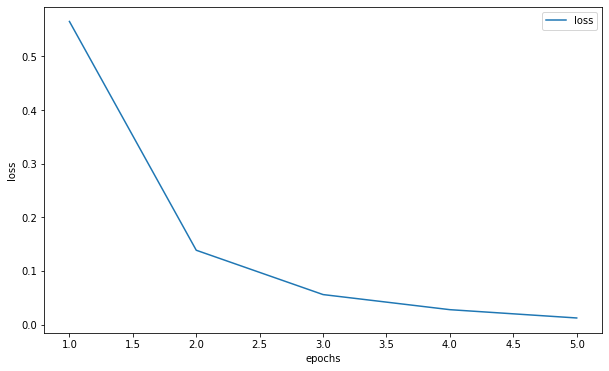

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
x = [*range(1, num_epochs+1, 1)]
plt.plot(x, loss_ls, label='loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

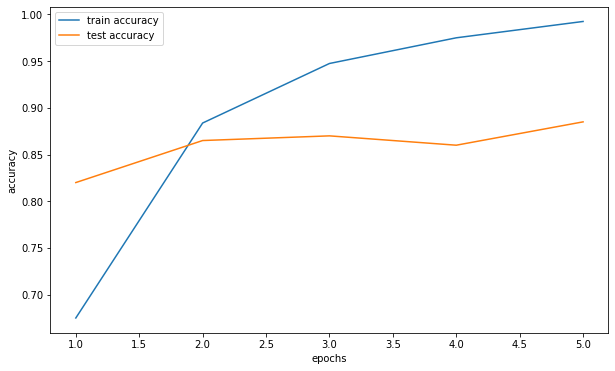

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(x, train_acc_ls, label='train accuracy')
plt.plot(x, test_acc_ls, label='test accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')

In [ ]:
x = torch.zeros(2, 1,3)
y = torch.squeeze(x,-1)
